# SELICRD Model

S - susceptable, E - exposed, L - latent, I - infected, C - critical, R - recovered, D - dead

Following:
https://towardsdatascience.com/infectious-disease-modelling-fit-your-model-to-coronavirus-data-2568e672dbc7

![title](model.jpg)

In [108]:
%matplotlib inline
from scipy.integrate import odeint
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import lmfit
from lmfit.lineshapes import gaussian, lorentzian
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import datetime
import re
import copy
base_dir = 'Data'

First, we define the system of differential equations modelling the flow between compartments

$$\begin{align*}
\dfrac{\delta S}{\delta t} &= - \beta  S \dfrac{I + L}{N}\\
\dfrac{\delta E}{\delta t} &= \beta  S \dfrac{I + L}{N} - \delta  E\\
\dfrac{\delta L}{\delta t} &= \delta  E - \epsilon  p_{L\rightarrow R}  L - \theta  (1 - p_{L\rightarrow R})  L\\
\dfrac{\delta I}{\delta t} &= \theta  (1 - p_{L\rightarrow R})  L - \gamma  (1 - p_{I\rightarrow C})  I  -\lambda  p_{I\rightarrow C}  I\\
\dfrac{\delta C}{\delta t} &= \lambda p_{I\rightarrow C}  I - \tau  \cdot (1 - p_{C\rightarrow D})  \cdot min(beds(t), C) - 
\rho  \cdot p_{C\rightarrow D}  \cdot \min(beds(t), C) - \max(0, C - beds(t))\\
\dfrac{\delta R}{\delta t} &= \gamma  (1 - p_{I\rightarrow R})  I + \tau  (1 - p_{C\rightarrow D})  \cdot \min(beds(t), C) + \epsilon  p_{L\rightarrow R}  L\\
\dfrac{\delta D}{\delta t} &= \rho  \cdot p_{C\rightarrow D}  \cdot min(beds(t), C) + max(0, C-beds(t))
\end{align*}$$

In [109]:
def deriv(y, t, N, beta, delta, epsilon, p_L_to_R, theta, gamma, p_C_to_D, p_I_to_C, lamda, tau, rho, beds):
    S, E, L, I, C, R, D = y
    dSdt = -beta(t) * S * (I + L) / N
    dEdt = beta(t) * S * (I + L) / N - delta * E
    dLdt = delta * E - epsilon * p_L_to_R * L - theta * (1 - p_L_to_R) * L
    dIdt = theta * (1 - p_L_to_R) * L - gamma * (1 - p_I_to_C) * I  - lamda * p_I_to_C * I
    dCdt = lamda * p_I_to_C * I - tau * (1 - p_C_to_D) * min(beds(t), C) - rho * p_C_to_D * min(beds(t), C) \
           - max(0, C - beds(t))
    dRdt = gamma * (1 - p_I_to_C) * I + tau * (1 - p_C_to_D) * min(beds(t), C) + epsilon * p_L_to_R * L
    dDdt = rho * p_C_to_D * min(beds(t), C) + max(0, C-beds(t))
    return dSdt, dEdt, dLdt, dIdt, dCdt, dRdt, dDdt

We can model the declining R0 as a logistical interpolation as "Stay at Home" orders are released and followed. 

In [110]:
# def logistic_R_0(t, R_0_start, k, x0, R_0_end):
#     if -k*(-t+x0) >= 500: return R_0_end
#     return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end
def R0_t(t, b, r_s):
    return (2 / np.pi) * np.arctan(-(t - b) / 10 * r_s) + 1.0

We can find the numerical solution to the ODEs 

In [111]:
# def Model(days, agegroups, beds_per_10k, R_0_start, k, x0, R_0_end, p_L_to_R, p_I_to_C, p_C_to_D, s):
#     # infection rate comes from current R0
#     def beta(t):
#         return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma
#     # model bed usage in the poplation
#     def beds(t):
#         beds_0 = beds_per_10k / 10_000 * N
#         return beds_0 + s*beds_0*t  # 0.003
#     # run model
#     N = sum(agegroups)
#     y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0
#     t = np.linspace(0, days, days)
#     ret = odeint(deriv, y0, t, args=(N, beta, delta, epsilon, p_L_to_R, theta, gamma, p_C_to_D, p_I_to_C, lamda, tau, rho, beds))
#     S, E, L, I, C, R, D = ret.T
#     R_0_over_time = [beta(i)/gamma for i in range(len(t))]
#     return t, S, E, L, I, C, R, D, R_0_over_time, beds, p_I_to_C, p_C_to_D
def Model(days, agegroups, beds_per_100k, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s):
    def beta(t):
        return alpha*R0_t(t, b, r_s)
    N = sum(agegroups)
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003
    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv, y0, t, args=(N, beta, delta, epsilon, p_L_to_R, theta, gamma, p_C_to_D, p_I_to_C, lamda, tau, rho, Beds))
    S, E, L, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/alpha for i in range(len(t))]
    return t, S, E, L, I, C, R, D, R_0_over_time, Beds, p_I_to_C, p_C_to_D

In [112]:
def plotter(t, S, E, L, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None):
    if S_1 is not None and S_2 is not None: 
        print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU: {S_2 * 100}")
    f, ax = plt.subplots(1,1,figsize=(20,4))
    if x_ticks is None:
        # ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, L, 'm', alpha=0.7, linewidth=2, label='Latent')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'c', alpha=0.7, linewidth=2, label='Critical')
        # ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
        # ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, L, 'm', alpha=0.7, linewidth=2, label='Latent')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'c', alpha=0.7, linewidth=2, label='Critical')
        # ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()
    ax.title.set_text('SELICRD Model')
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()
    f = plt.figure(figsize=(20,4))
    # sp1
    ax1 = f.add_subplot(131)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()
    ax1.title.set_text('R_0 over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    # sp2
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(delta*E[:i]) if sum(delta*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
        ax2.xaxis.set_major_locator(mdates.YearLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()
    ax2.title.set_text('Fatality Rate (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    # sp3
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
        ax3.xaxis.set_major_locator(mdates.YearLocator())
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax3.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()
    ax3.title.set_text('Deaths per day')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show();

Next, define the hyper-parameter rates of the model

In [113]:
gamma = 1.0 / 17.5 # 9 days from infection to recovery
delta = 1.0 / 2.5  # incubation period of four days
epsilon = 1.0 / 14.0 # two weeks for latent person to recover
theta = 1.0 /2.0 # three days for latent to show symptoms
lamda = 1.0 / 11.0 # five days for infected to be critical
tau = 1.0 / 11.5 # week for critical patients to recover
rho = 1.0 / 7.5 # 7.5 days from critical to death

## Parameter Fitting

In [114]:
params_init_min_max = {#"R_0_start": (3.0, 2.0, 10.0), "k": (2.5, 0.01, 10.0), "x0": (57, 20, 100), "R_0_end": (0.9, 0.01, 3.5), 
                       "p_L_to_R": (0.6, 0.0, 0.8),
                       "alpha": (0.3, 0.1, 5.7), 
                       "b": (20, 0, 40), "r_s": (1, 0.1, 60),
                       "p_I_to_C": (0.05, 0.001, 0.1), "p_C_to_D": (0.5, 0.005, 0.8),
                       "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}

In [115]:
worldData = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv", header = 0)
worldData.rename(columns={"countriesAndTerritories" : "country"}, inplace=True)
worldData["country"].replace({"United_States_of_America": "US"}, inplace=True)

In [116]:
#country = "China"
#countryData = worldData[worldData.country == country][::-1].reset_index(drop=True)
#countryData

In [117]:
#plt.plot(np.cumsum(countryData["deaths"]))

In [118]:
#countryData["deaths"][100:120]

In [119]:
#countryData["dateRep"][108]

In [120]:
# def run_and_plot(country, outbreak_shift):
#     #deaths
#     if country == 'China': 
#         countryData = pd.read_csv("Data/china_cases_severe_deaths_nhc.csv", header = 0)
#         # rename the column header so that it is same as other data
#         countryData.rename(columns={'confirmed_ttl':'cases_ttl'}, inplace=True) 
        
# #     else: deaths = pd.read_csv("Data/world_cases_deaths_EUopendataportal.csv", header = 0)
#     else:
#         worldData = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv", header = 0)
#         worldData.rename(columns={"countriesAndTerritories" : "country"}, inplace=True)
#         worldData.rename(columns={"dateRep" : "date"}, inplace=True)
#         worldData["country"].replace({"United_States_of_America": "US"}, inplace=True)
#         worldData["country"].replace({"United_Kingdom": "UK"}, inplace=True)
        
#         countryData = worldData[worldData.country == country][::-1].reset_index(drop=True)
        
#         # Handling anormally: make sure no negative number of deaths
#         # in Spain data, row index 146 has -1918 number of deaths which doesn't make sense
#         # make negative number of deaths to be zero
#         countryData.loc[countryData["deaths"] < 0] = 0

#         # create cumulative columns
#         countryData["cases_ttl"] = np.cumsum(countryData["cases"])
#         countryData["deaths_ttl"] = np.cumsum(countryData["deaths"])
    
#     # find the case when equal or more than 100 infection cases detected
#     countryData = countryData.loc[countryData["cases_ttl"].values>=100]
#     deathData = countryData["deaths_ttl"].values

#     # agegroups
#     ages = pd.read_csv("Data/agegroups_UNdata.csv")
#     agegroups = ages[ages.country_area == country].values[0][2:]
#     N = sum(agegroups) #ttl pop

#     # beds
#     beds = pd.read_csv("Data/beds_UNdata.csv", header=0)
#     beds = beds[['country_area','beds']]
#     beds = beds.rename(columns={"country_area": "Country", "beds": "ICU_Beds"})
#     beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
#     beds_per_10k = beds_lookup[country]

#     #create outbreak shift
#     days = outbreak_shift + len(deathData)
#     if outbreak_shift >= 0:y_data = np.concatenate((np.zeros(outbreak_shift), deathData))
#     else: y_data = deathData[-outbreak_shift:]

#     x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array
    
#     # fit model to deaths
# #     def fitter(x, R_0_start, k, x0, R_0_end, p_L_to_R, p_I_to_C, p_C_to_D, s):
# #         ret = Model(days, agegroups, beds_per_10k, R_0_start, k, x0, R_0_end, p_L_to_R, p_I_to_C, p_C_to_D, s)
# #         return ret[7][x]
#     def fitter(x, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s):
#         ret = Model(days, agegroups, beds_per_10k, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s)
#         return ret[7][x]
#     mod = lmfit.Model(fitter)
#     for kwarg, (init, mini, maxi) in params_init_min_max.items():
#         mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)
#     params = mod.make_params()
#     fit_method = "leastsq"
#     result = mod.fit(y_data, params, method="least_squares", x=x_data)
#     print(result.best_values)
#     print(np.mean(result.residual **2))
    
#     # forward predict
#     dates = countryData["date"].values
#     first_date = dates[0]
#     full_days = len(y_data) + 30
#     x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
#     predict_range = full_days - len(y_data)
#     forecast = Model(full_days, agegroups, beds_per_10k, **result.best_values)
#     death_projection = forecast[7]
    
#     fig, ax = plt.subplots()
#     ax.plot(x_data, y_data, label="Data")
#     ax.plot(x_data, death_projection[:len(y_data)], color="orange", label="Model fit")
#     ax.plot(np.arange(x_data[-1],x_data[-1]+predict_range), death_projection[len(y_data):], 
#          "--", color="orange", label="Model Prediction")
#     label_idx = np.arange(0, len(x_ticks), 15)
#     labels = x_ticks[label_idx].strftime("%m/%d")
#     location = np.arange(0, len(death_projection))
#     label_location = location[label_idx]; ax.set_xticks(label_location)
#     ax.set_xticklabels(labels, rotation=45); ax.set_ylabel("Deaths")
#     ax.set_title(country) ;ax.legend() ;fig.autofmt_xdate(); plt.show()

#     # plot 
#     full_days = 500 ## let's predict full 200 days
#     x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
#     print("Prediction for " + country)
#     plotter(*Model(full_days, agegroups, beds_per_10k, **result.best_values), x_ticks=x_ticks);

## United States

In [121]:
# run_and_plot("US", 0)

## China

In [122]:
# run_and_plot("China", 0)

## Brazil

In [123]:
# run_and_plot("Brazil", 0)

## India

In [124]:
# run_and_plot("India", 0)

## Germany

In [125]:
# run_and_plot("Germany", 0)

## Italy

In [126]:
# run_and_plot("Italy", 0)

## Spain

In [127]:
# run_and_plot("Spain", 0)

## United Kingdom

In [128]:
# run_and_plot("UK", 0)

## France

In [129]:
# run_and_plot("France", 0)

## Canada

In [130]:
# run_and_plot("Canada", 0)

## Netherlands

In [131]:
# run_and_plot("Netherlands", 0)

## Use Johns Hopkins Global Data 

* Notes:


On May 25, Spain announced yet another way of collecting data, by counting a death based on when it happened, instead of when authorities were notified about it.

As a result, the country’s death toll saw a 2,000 drop, and authorities have said that they would update the numbers weekly, warning that more changes might come, while still reporting daily numbers.

* Source : https://www.nytimes.com/interactive/2020/world/europe/spain-coronavirus-cases.html


China retroactively added over 1300 previously uncounted deaths from Wuhan to the COVID data in late April: https://www.nbcnews.com/news/world/coronavirus-china-announces-jump-death-toll-wuhan-china-n1186006

Brazilian government stopped publishing its numbers on its official site and wiped all previous data: https://www.theguardian.com/world/2020/jun/07/brazil-stops-releasing-covid-19-death-toll-and-wipes-data-from-official-site

In [132]:
def run_and_predict(country, outbreak_shift, pred_days = 60):

    #Get confirmed/deaths/recovered data (source: JHU)
    confirmed_df = pd.read_csv('Data/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
    deaths_df = pd.read_csv('Data/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
    recoveries_df = pd.read_csv('Data/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

    confirmed_df.rename(columns={"Country/Region" : "country"}, inplace=True)
    deaths_df.rename(columns={"Country/Region" : "country"}, inplace=True)
    recoveries_df.rename(columns={"Country/Region" : "country"}, inplace=True)

    confirmed_df["country"].replace({"United Kingdom": "UK"}, inplace=True)
    deaths_df["country"].replace({"United Kingdom": "UK"}, inplace=True)
    recoveries_df.rename(columns={"Country/Region" : "country"}, inplace=True)
    
    confirmed_df["country"].replace({"Korea, South": "South Korea"}, inplace=True)
    deaths_df["country"].replace({"Korea, South": "South Korea"}, inplace=True)
    recoveries_df.rename(columns={"Korea, South" : "South Korea"}, inplace=True)
   
    cols = confirmed_df.keys()  # 'Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20' ... etc

    confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
    deaths = deaths_df.loc[:, cols[4]:cols[-1]]
    recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

    dates = confirmed.keys()

    ## change format from broad to long
    countryConfirmed = [] 
    countryDeaths = []
    countryRecovery = []

    for i in dates:
        countryConfirmed.append(confirmed_df[confirmed_df['country']== country ][i].sum())
        countryDeaths.append(deaths_df[deaths_df['country']==country][i].sum())
        countryRecovery.append(recoveries_df[recoveries_df['country']==country][i].sum())

    countryConfirmed = np.array(countryConfirmed)
    countryDeaths = np.array(countryDeaths)
    countryRecovery = np.array(countryRecovery)

    
    #Get population by age groups
    ages = pd.read_csv("Data/agegroups_UNdata.csv")
    agegroups = ages[ages.country_area == country].values[0][2:]
    N = sum(agegroups) #ttl pop

    
    #Get beds per 10k
    beds = pd.read_csv("Data/beds_UNdata.csv", header=0)
    beds = beds[['country_area','beds']]
    beds = beds.rename(columns={"country_area": "Country", "beds": "ICU_Beds"})
    beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
    beds_per_10k = beds_lookup[country]

    
    #Create outbreak shift
    ## find the date when equal or more than 100 infection cases detected
    idx = np.where(countryConfirmed>=100)
    deathData = countryDeaths[idx]
    
    days = outbreak_shift + len(deathData)
    if outbreak_shift >= 0:y_data = np.concatenate((np.zeros(outbreak_shift), deathData))
    else: y_data = deathData[-outbreak_shift:]

    x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array
    
    
    #Fit model to deaths data
    def fitter(x, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s):
        ret = Model(days, agegroups, beds_per_10k, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s)
        return ret[7][x]
    mod = lmfit.Model(fitter)
    for kwarg, (init, mini, maxi) in params_init_min_max.items():
        mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)
    params = mod.make_params()
    fit_method = "leastsq"
    result = mod.fit(y_data, params, method="least_squares", x=x_data)
    # print(np.mean(result.residual **2))
    
    
    #Make forecasts for pred_days using best fit params
    #dates = countryData["date"].values
    first_date = dates[idx][0]
    full_days = len(y_data) + pred_days
    x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
    predict_range = full_days - len(y_data)
    forecast = Model(full_days, agegroups, beds_per_10k, **result.best_values)
    death_projection = forecast[7]
      
    return x_data, y_data, death_projection, predict_range, x_ticks, result.best_values, result

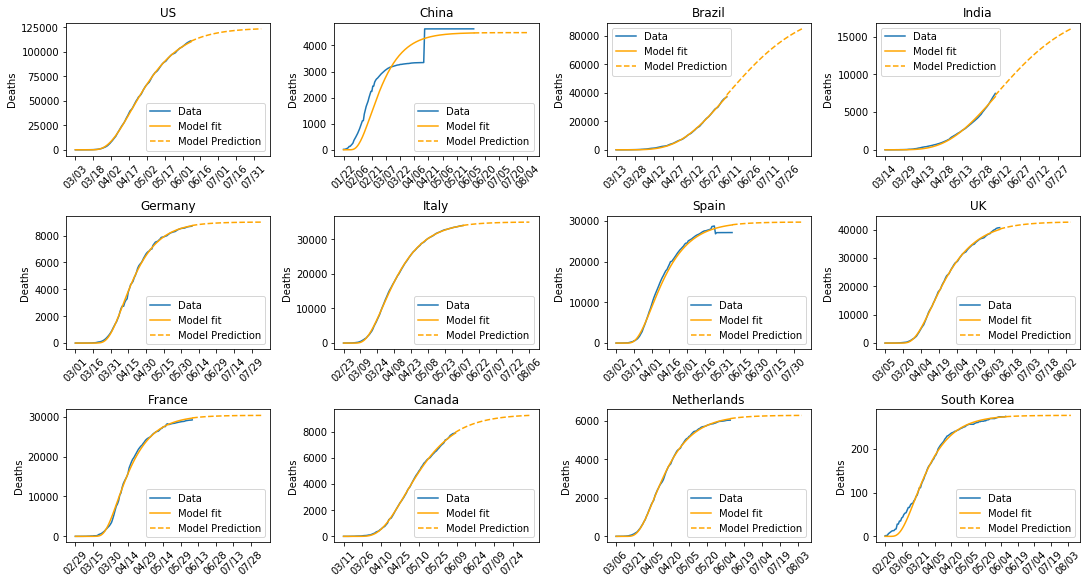

In [133]:
countries = ["US", "China", "Brazil", "India", "Germany", "Italy", "Spain", "UK", "France", "Canada", "Netherlands", "South Korea"]

params_init_min_max = {"p_L_to_R": (0.6, 0.0, 0.8),
                       "alpha": (0.3, 0.1, 5.7), 
                       "b": (20, 0, 40), "r_s": (1, 0.1, 60),
                       "p_I_to_C": (0.05, 0.001, 0.1), "p_C_to_D": (0.5, 0.005, 0.8),
                       "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}

fig, axs = plt.subplots(3,4, figsize=(15, 8), constrained_layout=True)
axs = axs.ravel()

country_param_dict = {}
country_death_prediction = {}
country_models = {}
country_dates = {}

for i,country in enumerate(countries):
    x_data, y_data, death_projection, predict_range, x_ticks, best_param, country_model  = run_and_predict(country, 0)
    
    country_param_dict[country] = best_param
    country_death_prediction[country] = (x_data, death_projection)
    country_models[country] = country_model
    country_dates[country] = x_ticks
    
    axs[i].plot(x_data, y_data, label="Data")
    axs[i].plot(x_data, death_projection[:len(y_data)], color="orange", label="Model fit")
    axs[i].plot(np.arange(x_data[-1],x_data[-1]+predict_range), death_projection[len(y_data):], 
         "--", color="orange", label="Model Prediction")
    
    label_idx = np.arange(0, len(x_ticks), 15)
    labels = x_ticks[label_idx].strftime("%m/%d")
    location = np.arange(0, len(death_projection))
    label_location = location[label_idx]; axs[i].set_xticks(label_location)
    axs[i].set_xticklabels(labels, rotation=45); axs[i].set_ylabel("Deaths")
    axs[i].set_title(country) ;axs[i].legend() ; #fig.autofmt_xdate(); 

plt.show()

In [134]:
# country_death_prediction

In [135]:
# countries = ["US", "China", "Brazil", "India", "Germany", "Italy", "Spain", "UK", "France", "Canada", "Netherlands", "South Korea"]
# country_dates["China"]

In [136]:
# country = "China"
# len(country_dates[country])

In [173]:
import copy
# Make and save predictions
country_interval = {}

for i,country in enumerate(countries):
    
    # get country-specific fitted params
    country_param = country_param_dict[country]

    # agegroups
    ages = pd.read_csv("Data/agegroups_UNdata.csv")
    agegroups = ages[ages.country_area == country].values[0][2:]

    # beds
    beds = pd.read_csv("Data/beds_UNdata.csv", header=0)
    beds = beds[['country_area','beds']]
    beds = beds.rename(columns={"country_area": "Country", "beds": "ICU_Beds"})
    beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
    beds_per_10k = beds_lookup[country]

    full_days = len(country_dates[country])
    
    forecast = Model(full_days, agegroups, beds_per_10k, **country_param)
#     plt.plot(forecast[7], label="projection")

    upper_param = copy.deepcopy(country_param)
    upper_param["p_C_to_D"] = upper_param["p_C_to_D"] + 0.1
    upper_forecast = Model(full_days, agegroups, beds_per_10k, **upper_param) #7th element is predictions
#     plt.plot(upper_forecast[7], label="upper")

    lower_param = copy.deepcopy(country_param)
    lower_param["p_C_to_D"] = lower_param["p_C_to_D"] - 0.1
    lower_forecast = Model(full_days, agegroups, beds_per_10k, **lower_param) #7th element is predictions
#     plt.plot(lower_forecast[7], label="lower")
#     plt.legend()
#     plt.show()

    #Avg deviation of pred upper/lower ranges from pred deaths
    print("\n***********"+ country + "***********")
    print("+",np.mean(upper_forecast[7] - forecast[7]))
    print("-",np.mean(forecast[7] - lower_forecast[7]))
    print("**************************")

    d = {"dates" : country_dates[country], 
         "prediction" :forecast[7],
         "+" :upper_forecast[7] - forecast[7], 
         "-" :lower_forecast[7] - forecast[7]}

    interval_df = pd.DataFrame(data=d)
    country_interval[country] = copy.deepcopy(interval_df)
    
    country_interval[country].to_csv('projection/' + country + "_death_projection.csv")
    #df.to_csv('file_name.csv')
    


***********US***********
+ 6531.604794153764
- 6996.130486689449
**************************

***********China***********
+ 303.9221219383694
- 326.287517920215
**************************

***********Brazil***********
+ 2869.47329061111
- 3061.5429197641756
**************************

***********India***********
+ 543.150847451035
- 579.4872426131865
**************************

***********Germany***********
+ 527.8010215217623
- 565.705693366369
**************************

***********Italy***********
+ 2129.9911974745933
- 2283.9439817362672
**************************

***********Spain***********
+ 1872.878065806267
- 2008.0858039330217
**************************

***********UK***********
+ 2443.3448598952928
- 2618.1171420640926
**************************

***********France***********
+ 1840.5303815908915
- 1973.1362225987793
**************************

***********Canada***********
+ 473.76551565759127
- 507.1824264985122
**************************

***********Netherlands***********
+

In [138]:
# country_interval["US"]

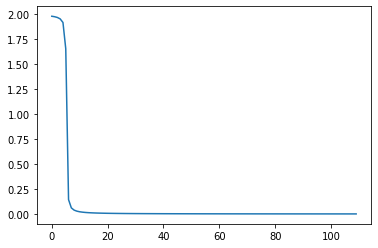

In [139]:
country = "South Korea"
# Use Johns Hopkins github data
confirmed_df = pd.read_csv('Data/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('Data/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('Data/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

confirmed_df.rename(columns={"Country/Region" : "country"}, inplace=True)
deaths_df.rename(columns={"Country/Region" : "country"}, inplace=True)
recoveries_df.rename(columns={"Country/Region" : "country"}, inplace=True)

confirmed_df["country"].replace({"United Kingdom": "UK"}, inplace=True)
deaths_df["country"].replace({"United Kingdom": "UK"}, inplace=True)
recoveries_df.rename(columns={"Country/Region" : "country"}, inplace=True)

confirmed_df["country"].replace({"Korea, South": "South Korea"}, inplace=True)
deaths_df["country"].replace({"Korea, South": "South Korea"}, inplace=True)
recoveries_df.rename(columns={"Korea, South" : "South Korea"}, inplace=True)


# cols = confirmed_df.keys() gives
# 'Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20' ... etc
cols = confirmed_df.keys()

confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

dates = confirmed.keys()

countryConfirmed = [] 
countryDeaths = []
countryRecovery = []

for i in dates:
    # case studies 
    countryConfirmed.append(confirmed_df[confirmed_df['country']== country ][i].sum())

    countryDeaths.append(deaths_df[deaths_df['country']==country][i].sum())

    countryRecovery.append(recoveries_df[recoveries_df['country']==country][i].sum())

countryConfirmed = np.array(countryConfirmed)
countryDeaths = np.array(countryDeaths)
countryRecovery = np.array(countryRecovery)


# find the case when equal or more than 100 infection cases detected
idx = np.where(countryConfirmed>=100)
deathData = countryDeaths[idx]

days = len(deathData)
t = np.linspace(0, days-1, days)

b = 5.276639391784356
r_s = 59.99999980327082

r0 = R0_t(t, b, r_s)

plt.plot(t, r0)

# def R0_t(t, b, r_s):
#     return (2 / np.pi) * np.arctan(-(t - b) / 10 * r_s) + 1.0


# Validation

In [140]:
from sklearn.model_selection import train_test_split

def Validate(country):
    outbreak_shift = 0
    
    if country == 'China': 
        deaths = pd.read_csv("Data/china_cases_severe_deaths_nhc.csv", header = 0)
        # rename the column header so that it is same as other data
        deaths.rename(columns={'confirmed_ttl':'cases_ttl'}, inplace=True) 
        
    else: deaths = pd.read_csv("Data/world_cases_deaths_EUopendataportal.csv", header = 0)
    
    deaths = deaths[deaths.country == country]

    # find the case when equal or more than 100 infection cases detected
    deaths = deaths.loc[deaths["cases_ttl"].values>=100]
    data = deaths["deaths_ttl"].values

    # agegroups
    ages = pd.read_csv("Data/agegroups_UNdata.csv")
    agegroups = ages[ages.country_area == country].values[0][2:]
    N = sum(agegroups) #ttl pop

    # beds
    beds = pd.read_csv("Data/beds_UNdata.csv", header=0)
    beds = beds[['country_area','beds']]
    beds = beds.rename(columns={"country_area": "Country", "beds": "ICU_Beds"})
    beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
    beds_per_10k = beds_lookup[country]

    #create outbreak shift
    days = outbreak_shift + len(data)
    if outbreak_shift >= 0:y_data = np.concatenate((np.zeros(outbreak_shift), data))
    else: y_data = data[-outbreak_shift:]

    x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array


    # This represents test size to be the last 30%, 20% and 10% of data
    test_sizes = [0.3, 0.2, 0.1, 0.05] 

    param_vec = []
    test_errors = []
    train_errors = []

    print("Country:", country)
    for test_size in test_sizes:
        print("Test set proportion:", test_size)
        X_train, X_test, Y_train, Y_test = train_test_split(x_data, y_data, test_size=test_size, shuffle = False) # make sure shuffle is False

        def fitter(x, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s):
                ret = Model(days, agegroups, beds_per_10k, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s)
                return ret[7][x]
        mod = lmfit.Model(fitter)
        for kwarg, (init, mini, maxi) in params_init_min_max.items():
            mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)
        params = mod.make_params()
        fit_method = "leastsq"
        result = mod.fit(Y_train, params, method="least_squares", x=X_train)

        ## store parameter values
        param_vec.append(result.best_values)

        # forward predict
        full_days = len(x_data)
        forecast = Model(full_days, agegroups, beds_per_10k, **result.best_values)
        death_projection = forecast[7]

        #L2 norm error
        #train_error = np.linalg.norm(Y_train - death_projection[:len(Y_train)], 2) ## divide by number of train set
        #test_error = np.linalg.norm(Y_test - death_projection[-len(Y_test):], 2) ## divide by number of test set

        #Mean-Absolute-Prediction-Error (MAPE)
        #train_error = np.mean(np.absolute((Y_train - death_projection[:len(Y_train)])/death_projection[:len(Y_train)]))
        test_error = np.mean(np.absolute((Y_test - death_projection[-len(Y_test):])/death_projection[-len(Y_test):]))
        
        #print("Train Error: {0}".format( train_error ))
        print("Test Error: {0}".format( test_error ))

        #train_errors.append(train_error)
        test_errors.append(test_error)

    best_case = np.argmin(test_errors)
    best_parameters = param_vec[best_case]

    print("Best Validation case is when test size is remaining {0} %".format(test_sizes[best_case]*100))
    
    plt.figure()
    plt.plot((1-np.array(test_sizes)) * 100, test_errors)
    plt.xlabel("Train Set Percentage")
    plt.ylabel(r"$L_2$ Norm Error")
    plt.title("{0} Data Validation".format(country))
    plt.show()
    
    return best_parameters

Country: US
Test set proportion: 0.3
Test Error: 0.043340203959289746
Test set proportion: 0.2
Test Error: 0.029191487553899265
Test set proportion: 0.1
Test Error: 0.02069039753435343
Test set proportion: 0.05
Test Error: 0.019394571550855066
Best Validation case is when test size is remaining 5.0 %


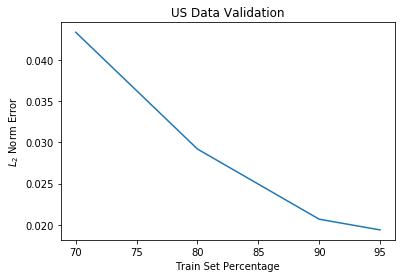

In [141]:
best_param_each_country = dict()

best_param_each_country["US"] = Validate("US")

Country: China
Test set proportion: 0.3
Test Error: 0.11217401204996909
Test set proportion: 0.2
Test Error: 0.07246219081005818
Test set proportion: 0.1
Test Error: 0.04900030445236623
Test set proportion: 0.05
Test Error: 0.038553735822305465
Best Validation case is when test size is remaining 5.0 %


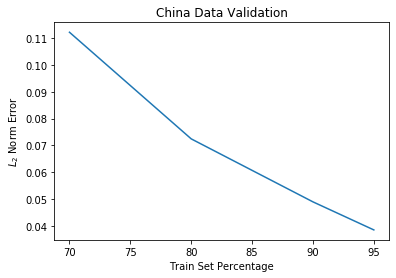

In [142]:
best_param_each_country["China"]  = Validate("China")

Country: Brazil
Test set proportion: 0.3
Test Error: 0.1846722710831232
Test set proportion: 0.2
Test Error: 0.06382571530107557
Test set proportion: 0.1
Test Error: 0.01039223989580394
Test set proportion: 0.05
Test Error: 0.013281678808711042
Best Validation case is when test size is remaining 10.0 %


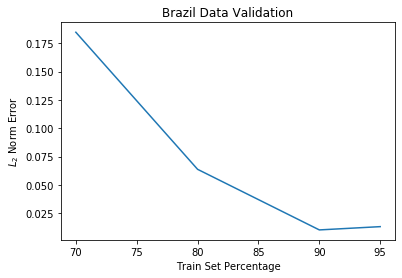

In [143]:
best_param_each_country["Brazil"]  = Validate("Brazil")

Country: India
Test set proportion: 0.3
Test Error: 0.17376009045403948
Test set proportion: 0.2
Test Error: 0.14304503373602268
Test set proportion: 0.1
Test Error: 0.12856755963453603
Test set proportion: 0.05
Test Error: 0.10843153305617532
Best Validation case is when test size is remaining 5.0 %


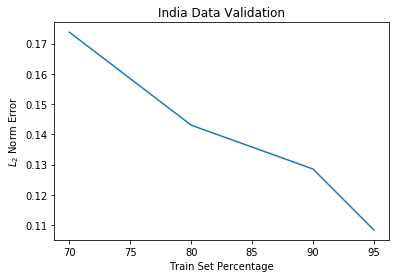

In [144]:
India_best_param = Validate("India")

Country: Germany
Test set proportion: 0.3
Test Error: 0.03417636842344295
Test set proportion: 0.2
Test Error: 0.015457011106818694
Test set proportion: 0.1
Test Error: 0.007630218260589664
Test set proportion: 0.05
Test Error: 0.00486728780272035
Best Validation case is when test size is remaining 5.0 %


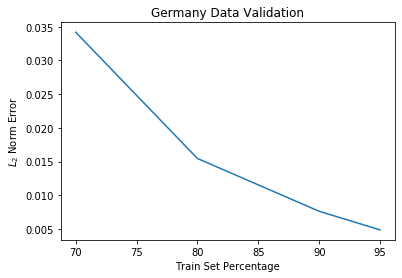

In [145]:
Germany_best_param = Validate("Germany")

Country: Italy
Test set proportion: 0.3
Test Error: 0.01075882150105478
Test set proportion: 0.2
Test Error: 0.004382088607382865
Test set proportion: 0.1
Test Error: 0.001121761620195847
Test set proportion: 0.05
Test Error: 0.001190396899488828
Best Validation case is when test size is remaining 10.0 %


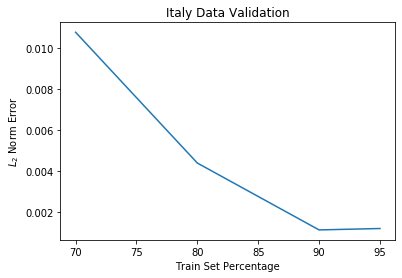

In [146]:
Italy_best_param = Validate("Italy")

Country: Spain
Test set proportion: 0.3
Test Error: 0.04662785611710233
Test set proportion: 0.2
Test Error: 0.05676094950312133
Test set proportion: 0.1
Test Error: 0.06762160040890082
Test set proportion: 0.05
Test Error: 0.06385778852019267
Best Validation case is when test size is remaining 30.0 %


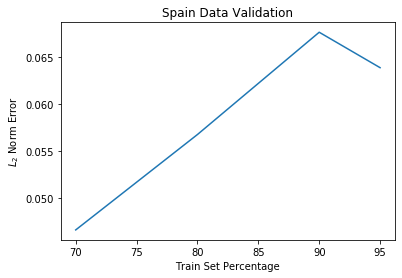

In [147]:
Spain_best_param = Validate("Spain")

Country: UK
Test set proportion: 0.3
Test Error: 0.02513173646239384
Test set proportion: 0.2
Test Error: 0.024945880356289425
Test set proportion: 0.1
Test Error: 0.025311031932490263
Test set proportion: 0.05
Test Error: 0.02522999378053271
Best Validation case is when test size is remaining 20.0 %


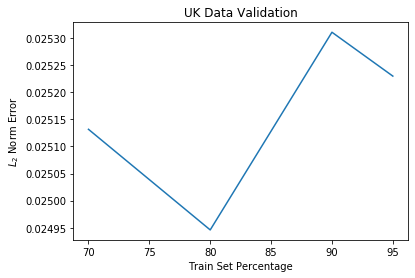

In [148]:
UK_best_param = Validate("UK")

Country: France
Test set proportion: 0.3
Test Error: 0.03836855307916157
Test set proportion: 0.2
Test Error: 0.026120152978699275
Test set proportion: 0.1
Test Error: 0.020545893424763872
Test set proportion: 0.05
Test Error: 0.01707918253294767
Best Validation case is when test size is remaining 5.0 %


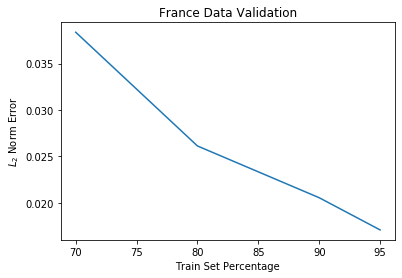

In [149]:
France_best_param = Validate("France")

Country: Canada
Test set proportion: 0.3
Test Error: 0.0627539690080355
Test set proportion: 0.2
Test Error: 0.013555951770153918
Test set proportion: 0.1
Test Error: 0.019505780438770937
Test set proportion: 0.05
Test Error: 0.01386446770823809
Best Validation case is when test size is remaining 20.0 %


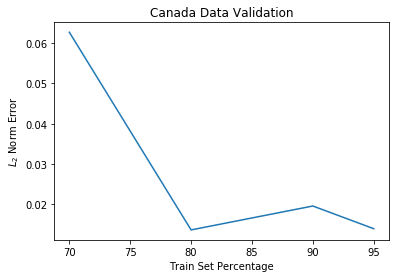

In [150]:
Canada_best_param = Validate("Canada")

Country: Netherlands
Test set proportion: 0.3
Test Error: 0.02797576173499706
Test set proportion: 0.2
Test Error: 0.020295469079604764
Test set proportion: 0.1
Test Error: 0.013003582126243123
Test set proportion: 0.05
Test Error: 0.011849053852360337
Best Validation case is when test size is remaining 5.0 %


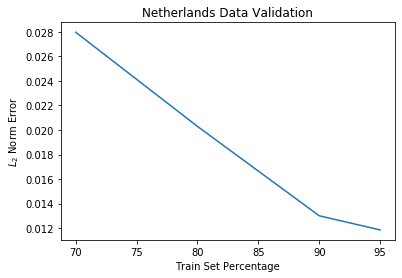

In [151]:
Netherlands_best_param = Validate("Netherlands")

# Predict Severe Cases from Predicted Deaths

In [152]:
#Need: date | actual deaths | pred deaths | pred deaths low| pred deaths high | actual severe | pred severe | pred severe low | pred severe high

In [153]:
#JHU General deaths data
deaths_df = pd.read_csv('Data/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
deaths_df.rename(columns={"Country/Region" : "country"}, inplace=True)
deaths_df["country"].replace({"United Kingdom": "UK"}, inplace=True)    
deaths_df["country"].replace({"Korea, South": "South Korea"}, inplace=True)

In [154]:
#JHU General confirmed cases data
confirmed_df = pd.read_csv('Data/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
confirmed_df.rename(columns={"Country/Region" : "country"}, inplace=True)
confirmed_df["country"].replace({"United Kingdom": "UK"}, inplace=True)    
confirmed_df["country"].replace({"Korea, South": "South Korea"}, inplace=True)

In [155]:
#Function to get [date | actual cases | actual deaths | pred deaths | pred deaths low| pred deaths high] for country
#Note: Not all countries have death data (e.g. Canada shows all 0s for reported deaths)
def get_deathsdata(country, actual_deaths = None):
    #Get pred deaths
    country_pred_deaths = copy.deepcopy(country_interval[country])
    country_pred_deaths["deaths_pred_low"] = country_pred_deaths["prediction"] + country_pred_deaths["-"]
    country_pred_deaths["deaths_pred_high"] = country_pred_deaths["prediction"] + country_pred_deaths["+"]
    country_pred_deaths["dates"] = country_pred_deaths["dates"].astype("string")

    country_pred_deaths.rename(columns={"dates" : "date", "prediction" : "deaths_pred"}, inplace=True)
    country_pred_deaths = country_pred_deaths.drop(columns = ["+","-"])

    if (actual_deaths is None):
        #Get actual deaths (JHU data)
        cols = deaths_df.keys()
        deaths = deaths_df.loc[:, cols[4]:cols[-1]]
        dates = deaths.keys()
        
        countryConfirmed = []
        countryDeaths = []

        for i in dates:
            countryConfirmed.append(confirmed_df[(confirmed_df["country"]==country) & (pd.isnull(confirmed_df["Province/State"]))][i].sum())
            countryDeaths.append(deaths_df[(deaths_df["country"]==country) & (pd.isnull(deaths_df["Province/State"]))][i].sum())

        country_actual_deaths = {'date' : pd.to_datetime(np.array(dates)).strftime('%Y-%m-%d'), 
                                 'confirmed_ttl' : np.array(countryConfirmed), 
                                 'deaths_ttl' : np.array(countryDeaths)}
        country_actual_deaths = pd.DataFrame(country_actual_deaths)

    else:
        country_actual_deaths = actual_deaths
        
    #Join the to get pred and actual deaths
    country_deaths = pd.merge(country_pred_deaths, country_actual_deaths,
                              how='left', 
                              left_on=["date"], 
                              right_on = ["date"])    
    
    return(country_deaths)

In [156]:
#Get severe case data separately since it comes from diff sources with diff formatting needs

In [157]:
#Function to make severe case predictions
#Input data in format [date | deaths_ttl | deaths_pred | deaths_pred_low | deaths_pred_high | severe_ttl]
#Returns a pandas df with 
# [dateind | date | deaths_ttl | deaths_pred | deaths_pred_low |deaths_pred_high | severe_ttl | pred_severe | pred_severe_low | pred_severe_high]
def predict_severe(data, c, window_size = 15, lag_days = 3):
    data = data.reset_index(drop=True)
    data["dateind"] = data.index
    
    #Filter for deaths, dropping missing obs
    deaths = data[["dateind", "deaths_pred", "deaths_pred_low", "deaths_pred_high"]].dropna()
    deaths = deaths.reset_index(drop=True)
    
    #Add severe case prediction category (= slope * c)
    deaths["severe_pred"] = np.nan
    deaths["severe_pred_low"] = np.nan
    deaths["severe_pred_high"] = np.nan
        
    #Calculate slopes over a rolling window
    for i in range(window_size, deaths.shape[0]+1):
        X = deaths[i-window_size: i]["dateind"].to_numpy().reshape(-1, 1)
        Y1 = deaths[i-window_size: i]["deaths_pred"].to_numpy().reshape(-1, 1)
        Y2 = deaths[i-window_size: i]["deaths_pred_low"].to_numpy().reshape(-1, 1)
        Y3 = deaths[i-window_size: i]["deaths_pred_high"].to_numpy().reshape(-1, 1)
        
        #Pred
        regressor1 = LinearRegression()  
        regressor1.fit(X, Y1)
        deaths.at[i-lag_days,"severe_pred"] = regressor1.coef_[0] * c
        
        #Pred_low
        regressor2 = LinearRegression()  
        regressor2.fit(X, Y2)
        deaths.at[i-lag_days,"severe_pred_low"] = regressor2.coef_[0] * c
        
        #Pred_high
        regressor3 = LinearRegression()  
        regressor3.fit(X, Y3)
        deaths.at[i-lag_days,"severe_pred_high"] = regressor3.coef_[0] * c

    #Join back onto full data
    data = pd.merge(data, deaths,  
                    how='left')
    
    return(data)

In [158]:
#Function to plot results
def plot_preds(data):
    plt.plot(data["date"], data["deaths_ttl"], label = "True Deaths")
    plt.plot(data["date"], data["severe_ttl"], label = "True Severe")
    
    plt.plot(data["date"], data["deaths_pred"], label = "Pred Deaths", linestyle = "--")
    plt.fill_between(data["date"], data["deaths_pred_low"], data["deaths_pred_high"], color='b', alpha=.1)

    plt.plot(data["date"], data["severe_pred"], label = "Pred Severe", linestyle = "--")
    plt.fill_between(data["date"], data["severe_pred_low"], data["severe_pred_high"], color='r', alpha=.1)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    #plt.xticks(rotation=45)
    
    x_ticks = pd.date_range(start=data['date'].min(), end = data['date'].max(), freq="D")
    label_idx = np.arange(0, len(x_ticks), 10)
    labels = x_ticks[label_idx].strftime("%m/%d")
    location = np.arange(0, len(data[["deaths_pred"]]))
    label_location = label_idx
    plt.xticks(ticks = label_location, labels = labels, rotation = 50)
    #plt.xticks(labels, rotation=45);
    
    
    plt.show()

# US

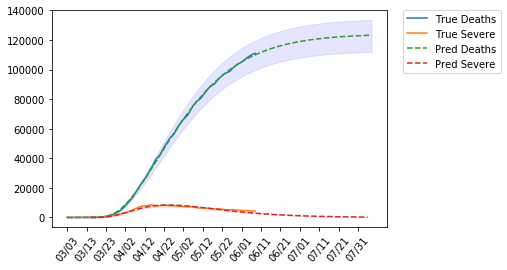

In [160]:
#US (predicts current hospitalizations)
us_deaths = get_deathsdata("US")

us_severe = pd.read_csv("Data/us_daily_severe_hosp.csv", header = 0)
us_severe = us_severe[["date", "hospitalizedCurrently"]].dropna()
us_severe['date'] = pd.to_datetime(us_severe['date'], format='%Y%m%d')
us_severe.rename(columns={"hospitalizedCurrently" : "severe_ttl"}, inplace=True)
us_severe["date"] = us_severe["date"].astype("string")

us = pd.merge(us_deaths, us_severe,  
              how='left', 
              left_on=["date"], 
              right_on = ["date"])
us["severe_ttl"] = us["severe_ttl"].bfill()/7 #Last observation carried backwards, daily avg

us_preds = predict_severe(us,4)
plot_preds(us_preds)

# Canada

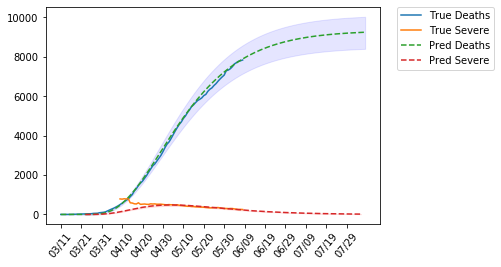

In [161]:
#Canada (predict ttl ICU)
canada_deaths = get_deathsdata("Canada")
canada_deaths = canada_deaths.drop(["deaths_ttl"], axis = 1)

canada_severe = pd.read_csv("Data/Canada_daily_severe_hosp.csv", header = 0)
canada_severe = canada_severe[canada_severe["Province"] == "CANADA"][["SummaryDate", "TotalDeaths", "TotalICU"]]
canada_severe = canada_severe.rename(columns = {"SummaryDate":"date", "TotalDeaths":"deaths_ttl", "TotalICU":"severe_ttl"})
canada_severe[["date"]] = canada_severe[["date"]].replace('/', '-', regex=True)
canada_severe[["date"]] = canada_severe[["date"]].replace(' .*', '', regex=True)

canada = pd.merge(canada_deaths, canada_severe,  
              how='left', 
              left_on=["date"], 
              right_on = ["date"])

canada_preds = predict_severe(canada, 3)
plot_preds(canada_preds)

# China

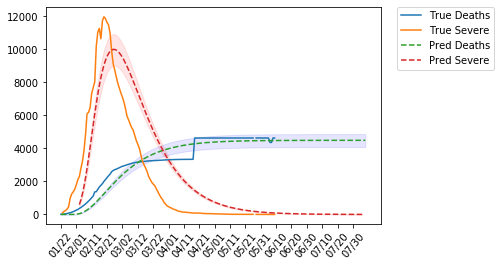

In [162]:
#China (predicts critical cases)
#(Note: Predicting on actual deaths gives better results since slope of pred and actual deaths curves are diff)
china_deaths = pd.read_csv("Data/china_cases_severe_deaths_nhc.csv", header = 0)
china_deaths = china_deaths[["date", "deaths_ttl"]]
china_deaths = get_deathsdata("China", china_deaths)

china_severe = pd.read_csv("Data/china_cases_severe_deaths_nhc.csv", header = 0)
china_severe = china_severe[["date", "severe_ttl"]]
china = pd.merge(china_deaths, china_severe,  
                 how='left', 
                 left_on=["date"], 
                 right_on = ["date"])

china_preds = predict_severe(china, 100)
plot_preds(china_preds)

# France

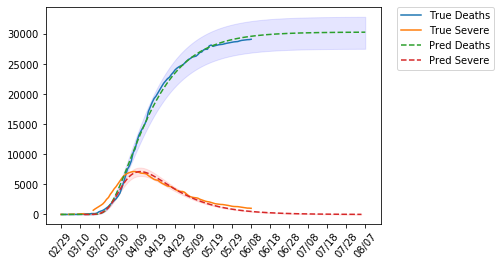

In [163]:
#France (predicts severe cases)
france_deaths = get_deathsdata("France")
france_severe = pd.read_csv("Data/france_cases_deaths_severe_recovered_ministresante.csv", header = 0)
france = pd.merge(france_deaths, france_severe[["date", "severe_ttl"]],  
              how='left', 
              left_on=["date"], 
              right_on = ["date"])

france_preds = predict_severe(france, 9)
plot_preds(france_preds)

# Italy

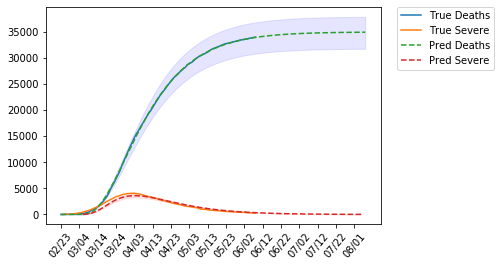

In [164]:
#Italy (predicts intensive care numbers)
italy_deaths = get_deathsdata("Italy")

italy_severe = pd.read_csv("Data/italy_daily_severe_hosp.csv", header = 0)
italy_severe = italy_severe[["data","terapia_intensiva"]]
italy_severe = italy_severe.rename(columns={"data":"date", "terapia_intensiva":"severe_ttl"})
italy_severe[["date"]] = italy_severe[["date"]].replace('T.*', '', regex=True)

italy = pd.merge(italy_deaths, italy_severe,  
                 how='left', 
                 left_on=["date"], 
                 right_on = ["date"])
                 
italy_preds = predict_severe(italy, 5)
plot_preds(italy_preds)

# Spain

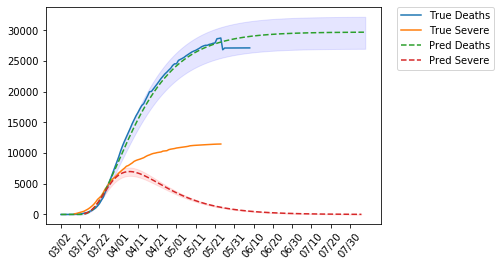

In [165]:
#Spain (predicts ttl hospitalized)
spain_deaths = get_deathsdata("Spain")

spain_severe = pd.read_csv("Data/spain_icu_hospitalization.csv", header = 0)
spain_severe = spain_severe[["fecha","total_hosp"]]
spain_severe = spain_severe.rename(columns={"fecha":"date", "total_hosp":"severe_ttl"})

spain = pd.merge(spain_deaths, spain_severe,  
                 how='left', 
                 left_on=["date"], 
                 right_on = ["date"])

spain_preds = predict_severe(spain, 10)
plot_preds(spain_preds)

# Netherlands

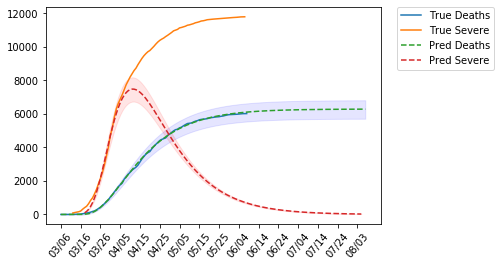

In [170]:
#Netherlands (predicts ttl hospitalized)
neth_deaths = get_deathsdata("Netherlands")

neth_severe = pd.read_csv("Data/netherlands_hospitalization_statista.csv", header = 0)
neth_severe = neth_severe[["date", "hospitalizations_ttl"]]
neth_severe = neth_severe.rename(columns = {"deaths":"deaths_ttl", "hospitalizations_ttl":"severe_ttl"})

neth = pd.merge(neth_deaths, neth_severe,  
                 how='left', 
                 left_on=["date"], 
                 right_on = ["date"])

neth_preds = predict_severe(neth, 50)
plot_preds(neth_preds)

# South Korea

# Brazil

# India

# Germany

# UK